In [508]:
import os
from typing import Optional, Literal

import torch
import optuna
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import math

from shared.utils import get_study_name, get_fl_study_name
from shared.data import OCTDLClass, prepare_dataset
from shared.model import ModelType, get_model_by_type
from shared.training import set_device
from shared.metrics import balanced_accuracy
from centralized.optimization import load_weights
from federated_learning.optimization import load_weights as load_weights_fl
from federated_learning.strategy import FLStrategy

In [674]:
LOSS_TYPE = "WeightedCrossEntropy"
OPTIMIZATION_MODE = "maximize_f1_macro"
FIGS_FOLDER = "figures"

In [108]:
def load_study(name: str, folder: str):
    db_name = "results.sqlite3"
    db_url = f"sqlite:///{os.path.join(folder, db_name)}"
    study: optuna.Study = optuna.load_study(
        study_name=name, storage=db_url)

    return study

In [109]:
def test_model(model: torch.nn.Module, test_loader: torch.utils.data.DataLoader):
    all_preds = []
    all_labels = []
    device = set_device()
    model.eval()
    model.to(device)
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return all_preds, all_labels

In [110]:
def run_model_test(
    model: torch.nn.Module, 
    test_loader: torch.utils.data.DataLoader,
    n_classes: int
):
    all_preds, all_labels = test_model(model, test_loader)
        
    bal_acc = balanced_accuracy(all_preds, all_labels)
    f1score_macro = metrics.f1_score(all_labels, all_preds, average='macro')

    if n_classes == 2:
        f1score_binary = metrics.f1_score(
            all_labels, all_preds, average='binary', pos_label=0)
    else:
        f1score_binary = None

    return bal_acc, f1score_macro, f1score_binary

In [224]:
def test_centralized(
    classes: list[OCTDLClass], 
    model_configs: list[tuple[ModelType, bool]],
    test_loader: torch.utils.data.DataLoader,
):
    df = pd.DataFrame(columns=['Model', 'Transfer Learning', 'Bal Acc', 'F1 Macro', 'F1 Score Binary'])
    df['Transfer Learning'] = df['Transfer Learning'].astype(bool)
    
    for model_name, transfer_learning in model_configs:
        study_name = get_study_name(
            classes, model_name, transfer_learning, LOSS_TYPE, OPTIMIZATION_MODE)
        study = load_study(study_name, "results_centralized")
        model = get_model_by_type(model_name, transfer_learning, classes, 0.0)
        best_trial = study.best_trial
        load_weights(model, study_name, best_trial.number)

        bal_acc, f1score_macro, f1score_binary = run_model_test(model, test_loader, len(classes))
        df.loc[len(df)] = [model_name, transfer_learning, bal_acc, f1score_macro, f1score_binary]

    return df
    

In [225]:
def test_federated(
    classes: list[OCTDLClass], 
    model_configs: list[tuple[ModelType, bool]],
    test_loader: torch.utils.data.DataLoader,
    fl_strategy: FLStrategy,
    n_clients: int,
    n_clients_per_round: int
):
    df = pd.DataFrame(columns=['Model', 'Transfer Learning', 'Bal Acc', 'F1 Macro', 'F1 Score Binary', 'Clients per round'])
    df['Transfer Learning'] = df['Transfer Learning'].astype(bool)
    
    for model_name, transfer_learning in model_configs:
        study_name = get_fl_study_name(
                classes, model_name, transfer_learning, LOSS_TYPE, OPTIMIZATION_MODE,
                n_clients, n_clients_per_round)
        study = load_study(study_name, f"results_{fl_strategy}")
        model = get_model_by_type(model_name, transfer_learning, classes, 0.0)
        best_trial = study.best_trial
        load_weights_fl(fl_strategy, model, study_name, best_trial.number)

        bal_acc, f1score_macro, f1score_binary = run_model_test(model, test_loader, len(classes))
        df.loc[len(df)] = [model_name, transfer_learning, bal_acc, f1score_macro, f1score_binary, n_clients_per_round]

    return df

In [226]:
amd_model_configs: list[tuple[ModelType, bool]] = [
    ('ResNet18', False), ('ResNet18', True), ('ResNet50', False), ('MobileNetV2', True)
]
multiclass_model_configs: list[tuple[ModelType, bool]] = [
    ('ResNet50', False), ('MobileNetV2', True)
]

In [227]:
amd_classes = [OCTDLClass.AMD, OCTDLClass.NO]
_, _, amd_test_loader = prepare_dataset(
        classes=amd_classes, augmentation=False, batch_size=1, validation_batch_size=32)

multiclass_classes = [OCTDLClass.AMD, OCTDLClass.DME, OCTDLClass.ERM, OCTDLClass.NO, OCTDLClass.RAO, OCTDLClass.RVO, OCTDLClass.VID]
_, _, multiclass_test_loader = prepare_dataset(
        classes=multiclass_classes, augmentation=False, batch_size=1, validation_batch_size=32)

In [480]:
def get_result_values(
    results: pd.DataFrame, 
    model: ModelType, 
    transfer_learning: bool, 
    clients: Optional[int] = None,
    reduction: Optional[Literal['max', 'mean']] = 'max'
):
    filtered_results = results[
        (results['Model'] == model) 
        & (results['Transfer Learning'] == transfer_learning)
    ]
    
    if clients is not None:
        filtered_results = filtered_results[filtered_results['Clients per round'] == clients]

    bal_acc = None
    f1_macro = None
    f1_binary = None

    if len(filtered_results) > 1:
        if reduction == 'max':
            bal_acc = filtered_results['Bal Acc'].max()
            f1_macro = filtered_results['F1 Macro'].max()
            f1_binary = filtered_results['F1 Score Binary'].max() if filtered_results['F1 Score Binary'].notna().any() else None
        elif reduction == 'mean':
            bal_acc = filtered_results['Bal Acc'].mean()
            f1_macro = filtered_results['F1 Macro'].mean()
            f1_binary = filtered_results['F1 Score Binary'].mean() if filtered_results['F1 Score Binary'].notna().any() else None

    elif len(filtered_results) == 1:
        row = filtered_results.iloc[0]
        bal_acc = row['Bal Acc']
        f1_macro = row['F1 Macro']
        f1_binary = row['F1 Score Binary'] if pd.notna(row['F1 Score Binary']) else None

    if f1_binary is None:
        return bal_acc, f1_macro
        
    return bal_acc, f1_macro, f1_binary


In [741]:
def save_plot(plt, title):
    if not os.path.exists(FIGS_FOLDER):
        os.makedirs(FIGS_FOLDER)
    plt.savefig(os.path.join(FIGS_FOLDER , f"{title}.png"), bbox_inches='tight')

In [770]:
def plot_metric_comparison(
    bar_names: list,
    subbar_names: list,
    plot_data: list,
    colors: list,
    plot_title: str,
    xlabel: str = 'Metrics',
    ylabel: str = 'Test F1 Score Macro',
    horizontal: bool = False,
    height: int = 4,
    legend_pos: str = "lower left",
    lower_y_lim: float = 0.5
):
    assert len(plot_data) == len(bar_names), "Length of plot_data must match number of bar_names"
    assert all(len(data) == len(subbar_names) for data in plot_data), "Each entry in plot_data must have the same length as subbar_names"
    font = {'size': 10}
    plt.rc('font', **font)
    
    x = np.arange(len(bar_names))
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, height))

    for i, subbar_name in enumerate(subbar_names):
        model_data = [plot_data[j][i] for j in range(len(bar_names))]

        if horizontal:
            bars = ax.barh(x + (i - len(subbar_names) / 2) * width, model_data, width, label=subbar_name, color=colors[i])
            for bar in bars:
                xval = bar.get_width()
                ax.text(xval, bar.get_y() + bar.get_height() / 2, round(xval, 3), va='center', ha='left', fontsize=10)
        else:
            bars = ax.bar(x + (i - len(subbar_names) // 2) * width, model_data, width, label=subbar_name, color=colors[i])
            for bar in bars:
                yval = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), ha='center', va='bottom', fontsize=10)

    if horizontal:
        ax.set_xlabel(ylabel)
        ax.set_ylabel(xlabel)
        ax.set_yticks(x)
        ax.set_yticklabels(bar_names)
        ax.invert_yaxis()
        plt.xticks(np.arange(0.0, 1.01, 0.1))
        plt.xlim(lower_y_lim, 1.1)
    else:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xticks(x)
        ax.set_xticklabels(bar_names)
        plt.yticks(np.arange(0.0, 1.01, 0.1))
        plt.ylim(lower_y_lim, 1.1)

    ax.legend(loc=legend_pos)

    plt.tight_layout()
    print(plot_title)
    save_plot(plt, plot_title)
    plt.show()

In [771]:
def effect_size(p1, p2):
    arcsine_root = lambda p: 2 * math.asin(math.sqrt(p))

    return abs(arcsine_root(p1) - arcsine_root(p2))

In [920]:
effect_size(0.973, 0.89), effect_size(0.989, 0.9962)

(0.3459998619278095, 0.08678175256370269)

# Centralized Experiments #

## Use case 1: AMD diagnosis ##

In [228]:
test_result_amd_centralized = test_centralized(amd_classes, amd_model_configs, amd_test_loader)

In [883]:
test_result_amd_centralized

,Model,Transfer Learning,Bal Acc,F1 Macro,F1 Score Binary
0,ResNet18,False,0.953283,0.942095,0.971910
1,ResNet18,True,0.963131,0.938112,0.968661
2,ResNet50,False,0.928030,0.939094,0.972527
3,MobileNetV2,True,0.929545,0.918934,0.960674


In [886]:
f1_macro_centr_resnet18_tl = test_result_amd_centralized.iloc[1]["F1 Macro"]
f1_macro_centr_mobilenet_tl = test_result_amd_centralized.iloc[3]["F1 Macro"]
f1_macro_centr_resnet18_tl, f1_macro_centr_mobilenet_tl

(0.9381119969355263, 0.9189335698797556)

## Use case 2: all classes ##

In [230]:
test_result_all_classes_centralized = test_centralized(multiclass_classes, multiclass_model_configs, multiclass_test_loader)

In [231]:
test_result_all_classes_centralized

,Model,Transfer Learning,Bal Acc,F1 Macro,F1 Score Binary
0,ResNet50,False,0.662992,0.509370,None
1,MobileNetV2,True,0.668634,0.599519,None


# Federated Learning Experiments #

## Use case 1: AMD diagnosis ##

In [802]:
test_results_amd_fedavg_10 = test_federated(
    amd_classes, amd_model_configs, amd_test_loader, 'FedAvg', 20, 10)
test_results_amd_fedavg_5 = test_federated(
    amd_classes, amd_model_configs, amd_test_loader, 'FedAvg', 20, 5)
test_results_amd_fedavg_3 = test_federated(
    amd_classes, amd_model_configs, amd_test_loader, 'FedAvg', 20, 3)

In [803]:
fedavg_results_amd = pd.concat([test_results_amd_fedavg_10, test_results_amd_fedavg_5, test_results_amd_fedavg_3], ignore_index=True)

In [804]:
fedavg_results_amd

,Model,Transfer Learning,Bal Acc,F1 Macro,F1 Score Binary,Clients per round
0,ResNet18,False,0.922475,0.927870,0.966851,10
1,ResNet18,True,0.946970,0.941391,0.972067,10
2,ResNet50,False,0.894697,0.875530,0.937500,10
3,MobileNetV2,True,0.917677,0.907353,0.955056,10
4,ResNet18,False,0.937121,0.945547,0.975207,5
5,ResNet18,True,0.950505,0.936681,0.969014,5
6,ResNet50,False,0.863131,0.867761,0.939227,5
7,MobileNetV2,True,0.938636,0.925168,0.963380,5
8,ResNet18,False,0.955303,0.958195,0.980609,3
9,ResNet18,True,0.946970,0.941391,0.972067,3


In [235]:
test_results_amd_fedbuff_10 = test_federated(
    amd_classes, amd_model_configs, amd_test_loader, 'FedBuff', 20, 10)
test_results_amd_fedbuff_5 = test_federated(
    amd_classes, amd_model_configs, amd_test_loader, 'FedBuff', 20, 5)
test_results_amd_fedbuff_3 = test_federated(
    amd_classes, amd_model_configs, amd_test_loader, 'FedBuff', 20, 3)

In [236]:
fedbuff_results_amd = pd.concat([eval_results_amd_fedbuff_10, eval_results_amd_fedbuff_5, eval_results_amd_fedbuff_3], ignore_index=True)

In [237]:
fedbuff_results_amd

,Model,Transfer Learning,Bal Acc,F1 Macro,F1 Score Binary,Clients per round
0,ResNet18,False,0.754545,0.651087,0.737201,10
1,ResNet18,True,0.617677,0.602750,0.783626,10
2,ResNet50,False,0.516919,0.488824,0.856436,10
3,MobileNetV2,True,0.811111,0.772456,0.873156,10
4,ResNet18,False,0.696717,0.661472,0.801205,5
5,ResNet18,True,0.806061,0.787381,0.891429,5
6,ResNet50,False,0.561364,0.564827,0.820375,5
7,MobileNetV2,True,0.686111,0.663439,0.815249,5
8,ResNet18,False,0.562626,0.566575,0.837696,3
9,ResNet18,True,0.685354,0.667594,0.823188,3


AMD Diagnosis, test metrics comparison of best models: Centralized vs. FedAvg


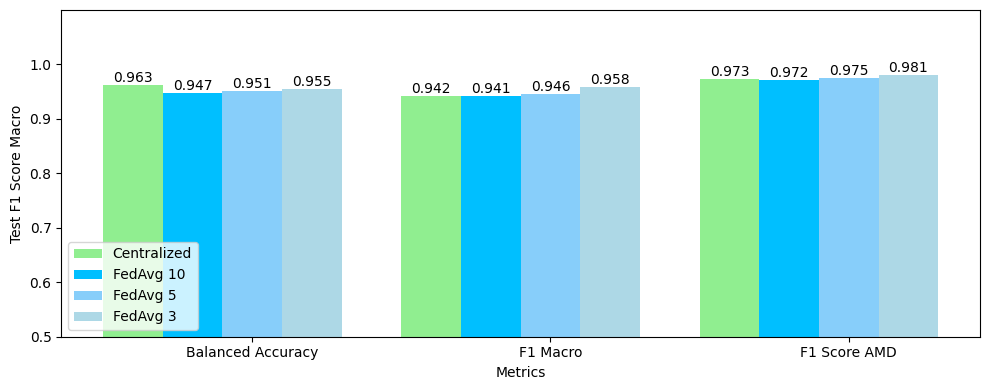

Effect size of best FedAvg performance:
 Bal Acc 0.0396 F1 Macro 0.0742 F1 Binary 0.0536


In [784]:
metric_names = ['Balanced Accuracy', 'F1 Macro', 'F1 Score AMD']
bal_acc_values = [
    test_result_amd_centralized['Bal Acc'].max(),
    test_results_amd_fedavg_10['Bal Acc'].max(),
    test_results_amd_fedavg_5['Bal Acc'].max(),
    test_results_amd_fedavg_3['Bal Acc'].max()
]

f1_macro_values = [
    test_result_amd_centralized['F1 Macro'].max(),
    test_results_amd_fedavg_10['F1 Macro'].max(),
    test_results_amd_fedavg_5['F1 Macro'].max(),
    test_results_amd_fedavg_3['F1 Macro'].max()
]

f1_binary_values = [
    test_result_amd_centralized['F1 Score Binary'].max(),
    test_results_amd_fedavg_10['F1 Score Binary'].max(),
    test_results_amd_fedavg_5['F1 Score Binary'].max(),
    test_results_amd_fedavg_3['F1 Score Binary'].max()
]
colors = ('lightgreen', 'deepskyblue', 'lightskyblue', 'lightblue')
sources = ['Centralized', 'FedAvg 10', 'FedAvg 5', 'FedAvg 3']
plot_metric_comparison(
    bar_names=metric_names,
    subbar_names=sources,
    plot_data=[bal_acc_values, f1_macro_values, f1_binary_values],
    colors=colors,
    plot_title="AMD Diagnosis, test metrics comparison of best models: Centralized vs. FedAvg",
)
effect_size_bal_acc = effect_size(bal_acc_values[0], max(bal_acc_values[1:4]))
effect_size_f1_macro = effect_size(f1_macro_values[0], max(f1_macro_values[1:4]))
effect_size_f1_bin = effect_size(f1_binary_values[0], max(f1_binary_values[1:4]))

print(
    "Effect size of best FedAvg performance:\n",
    f"Bal Acc {effect_size_bal_acc:.4f}",
    f"F1 Macro {effect_size_f1_macro:.4f}",
    f"F1 Binary {effect_size_f1_bin:.4f}",
)

AMD Diagnosis, test metrics comparison of best models: Centralized vs. FedBuff


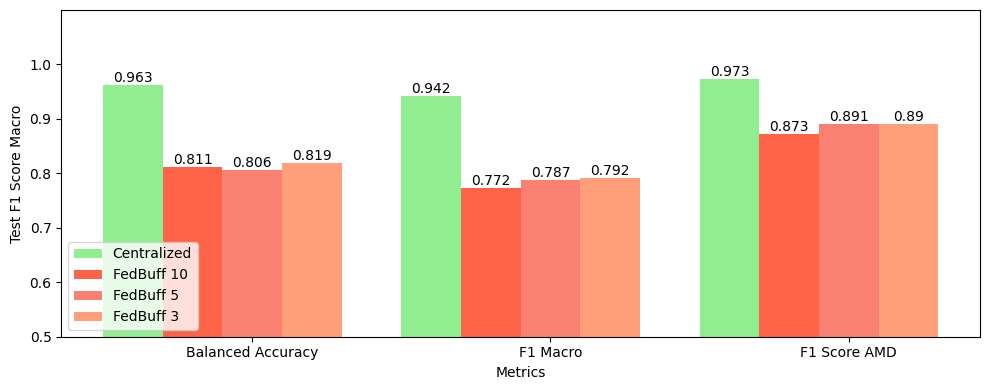

Effect size of best FedBuff performance:
 Bal Acc 0.4933 F1 Macro 0.4615 F1 Binary 0.3385


In [785]:
bal_acc_values = [
    test_result_amd_centralized['Bal Acc'].max(),
    test_results_amd_fedbuff_10['Bal Acc'].max(),
    test_results_amd_fedbuff_5['Bal Acc'].max(),
    test_results_amd_fedbuff_3['Bal Acc'].max()
]

f1_macro_values = [
    test_result_amd_centralized['F1 Macro'].max(),
    test_results_amd_fedbuff_10['F1 Macro'].max(),
    test_results_amd_fedbuff_5['F1 Macro'].max(),
    test_results_amd_fedbuff_3['F1 Macro'].max()
]

f1_binary_values = [
    test_result_amd_centralized['F1 Score Binary'].max(),
    test_results_amd_fedbuff_10['F1 Score Binary'].max(),
    test_results_amd_fedbuff_5['F1 Score Binary'].max(),
    test_results_amd_fedbuff_3['F1 Score Binary'].max()
]
colors = ('lightgreen', 'tomato', 'salmon', 'lightsalmon')
sources = ['Centralized', 'FedBuff 10', 'FedBuff 5', 'FedBuff 3']
plot_metric_comparison(
    bar_names=metric_names,
    subbar_names=sources,
    plot_data=[bal_acc_values, f1_macro_values, f1_binary_values],
    colors=colors,
    plot_title="AMD Diagnosis, test metrics comparison of best models: Centralized vs. FedBuff",
)
effect_size_bal_acc = effect_size(bal_acc_values[0], max(bal_acc_values[1:4]))
effect_size_f1_macro = effect_size(f1_macro_values[0], max(f1_macro_values[1:4]))
effect_size_f1_bin = effect_size(f1_binary_values[0], max(f1_binary_values[1:4]))

print(
    "Effect size of best FedBuff performance:\n",
    f"Bal Acc {effect_size_bal_acc:.4f}",
    f"F1 Macro {effect_size_f1_macro:.4f}",
    f"F1 Binary {effect_size_f1_bin:.4f}",
)

In [807]:
performance_data = []
for model, tl in amd_model_configs:
    _, centralized_f1_macro, _ = get_result_values(
        test_result_amd_centralized,
        model=model,
        transfer_learning=tl,
    )
    _, fedavg_f1_macro, _ = get_result_values(
        fedavg_results_amd,
        model=model,
        transfer_learning=tl,
        reduction='max'
    )
    _, fedbuff_f1_macro, _ = get_result_values(
        fedbuff_results_amd,
        model=model,
        transfer_learning=tl,
        reduction='max'
    )
    performance_data.append([centralized_f1_macro, fedavg_f1_macro, fedbuff_f1_macro])

In [808]:
performance_data

[[0.9420954070569683, 0.958194617398155, 0.6614719748559454],
 [0.9381119969355263, 0.9413906624102155, 0.7873809523809524],
 [0.9390939249429815, 0.9316155657257745, 0.5680147058823529],
 [0.9189335698797556, 0.9251684017146357, 0.7918608987506992]]

AMD Diagnosis, test F1 score macro comparison between model configurations


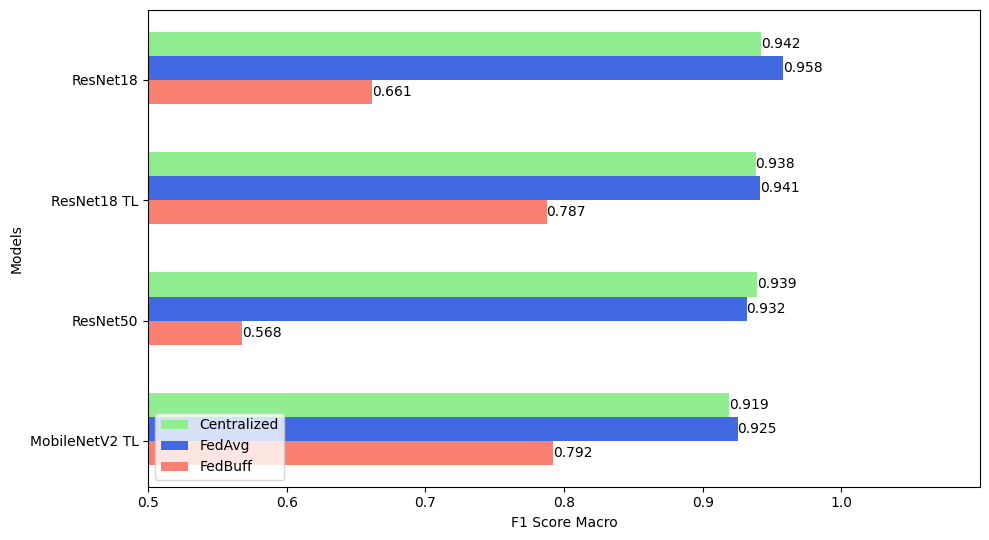

ResNet18/Centralized FedAvg: 0.0742
 ResNet18/Centralized FedBuff: 0.7559
 ResNet18-TL/Centralized FedAvg: 0.0138
 ResNet18-TL/Centralized FedBuff: 0.4557
 ResNet50/Centralized FedAvg: 0.0304
 ResNet50/Centralized FedBuff: 0.9356
 MobileNet-TL/Centralized FedAvg: 0.0233
 MobileNet-TL/Centralized FedBuff: 0.3701



In [809]:
# TODO: change scores to f1_macro in the plot!!
colors = ('lightgreen', 'royalblue', 'salmon')
plot_metric_comparison(
    bar_names=[f"{model}{' TL' if tl else ''}" for model, tl in amd_model_configs],
    subbar_names=['Centralized', 'FedAvg', 'FedBuff'],
    plot_data=performance_data,
    colors=colors,
    plot_title="AMD Diagnosis, test F1 score macro comparison between model configurations",
    horizontal=True,
    xlabel='Models',
    ylabel='F1 Score Macro',
    height=5.5
)
effect_size_resnet18_fedavg = effect_size(performance_data[0][0], performance_data[0][1])
effect_size_resnet18_fedbuff = effect_size(performance_data[0][0], performance_data[0][2])

effect_size_resnet18_tl_fedavg = effect_size(performance_data[1][0], performance_data[1][1])
effect_size_resnet18_tl_fedbuff = effect_size(performance_data[1][0], performance_data[1][2])


effect_size_resnet50_fedavg = effect_size(performance_data[2][0], performance_data[2][1])
effect_size_resnet50_fedbuff = effect_size(performance_data[2][0], performance_data[2][2])

effect_size_mobilenet_tl_fedavg = effect_size(performance_data[3][0], performance_data[3][1])
effect_size_mobilenet_tl_fedbuff = effect_size(performance_data[3][0], performance_data[3][2])

print(
    f"ResNet18/Centralized FedAvg: {effect_size_resnet18_fedavg:.4f}\n",
    f"ResNet18/Centralized FedBuff: {effect_size_resnet18_fedbuff:.4f}\n",
    f"ResNet18-TL/Centralized FedAvg: {effect_size_resnet18_tl_fedavg:.4f}\n",
    f"ResNet18-TL/Centralized FedBuff: {effect_size_resnet18_tl_fedbuff:.4f}\n",
    f"ResNet50/Centralized FedAvg: {effect_size_resnet50_fedavg:.4f}\n",
    f"ResNet50/Centralized FedBuff: {effect_size_resnet50_fedbuff:.4f}\n",
    f"MobileNet-TL/Centralized FedAvg: {effect_size_mobilenet_tl_fedavg:.4f}\n",
    f"MobileNet-TL/Centralized FedBuff: {effect_size_mobilenet_tl_fedbuff:.4f}\n",
)

## Use case 2: All classes ##

In [762]:
multiclass_model_configs = [('ResNet50', False), ('MobileNetV2', True)]

In [450]:
test_results_multiclass_fedavg_10 = test_federated(
    multiclass_classes, multiclass_model_configs, multiclass_test_loader, 'FedAvg', 20, 10)
test_results_multiclass_fedavg_5 = test_federated(
    multiclass_classes, multiclass_model_configs, multiclass_test_loader, 'FedAvg', 20, 5)
test_results_multiclass_fedavg_3 = test_federated(
    multiclass_classes, multiclass_model_configs, multiclass_test_loader, 'FedAvg', 20, 3)

In [451]:
fedavg_results_multiclass = pd.concat([test_results_multiclass_fedavg_10, test_results_multiclass_fedavg_5, test_results_multiclass_fedavg_3], ignore_index=True)

In [452]:
fedavg_results_multiclass

,Model,Transfer Learning,Bal Acc,F1 Macro,F1 Score Binary,Clients per round
0,ResNet50,False,0.394179,0.424134,None,10
1,MobileNetV2,True,0.613119,0.600805,None,10
2,ResNet50,False,0.526965,0.545813,None,5
3,MobileNetV2,True,0.618221,0.612459,None,5
4,ResNet50,False,0.616775,0.678056,None,3
5,MobileNetV2,True,0.669543,0.658387,None,3


In [455]:
test_results_multiclass_fedbuff_10 = test_federated(
    multiclass_classes, multiclass_model_configs, multiclass_test_loader, 'FedBuff', 20, 10)
test_results_multiclass_fedbuff_5 = test_federated(
    multiclass_classes, multiclass_model_configs, multiclass_test_loader, 'FedBuff', 20, 5)
test_results_multiclass_fedbuff_3 = test_federated(
    multiclass_classes, multiclass_model_configs, multiclass_test_loader, 'FedBuff', 20, 3)

In [763]:
fedbuff_results_multiclass = pd.concat([test_results_multiclass_fedbuff_10, test_results_multiclass_fedbuff_5, test_results_multiclass_fedbuff_3], ignore_index=True)

In [764]:
fedbuff_results_multiclass

,Model,Transfer Learning,Bal Acc,F1 Macro,F1 Score Binary,Clients per round
0,ResNet50,False,0.126136,0.107064,None,10
1,MobileNetV2,True,0.276997,0.259011,None,10
2,ResNet50,False,0.184754,0.158049,None,5
3,MobileNetV2,True,0.266908,0.294756,None,5
4,ResNet50,False,0.141519,0.113728,None,3
5,MobileNetV2,True,0.204247,0.194383,None,3


In [789]:
metric_names = ['Balanced Accuracy', 'F1 Macro']

All classes, test metrics comparison of best models: Centralized vs. FedAvg


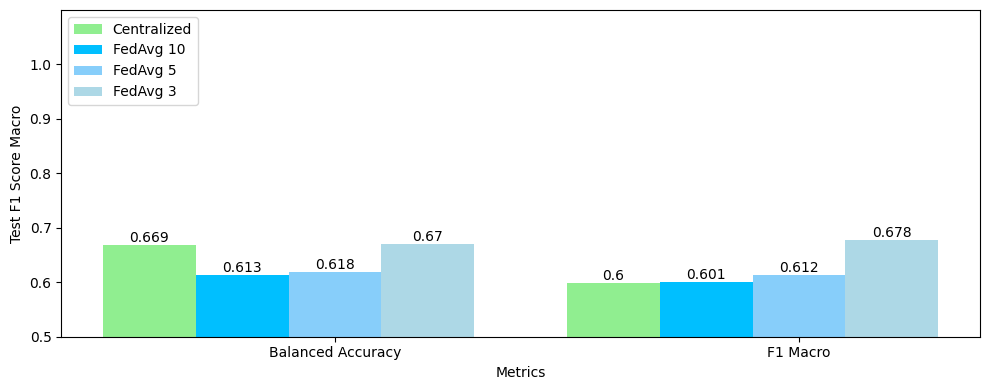

Effect size of best FedBuff performance:
 Bal Acc 0.0019 F1 Macro 0.1637


In [790]:
bal_acc_values = [
    test_result_all_classes_centralized['Bal Acc'].max(),
    test_results_multiclass_fedavg_10['Bal Acc'].max(),
    test_results_multiclass_fedavg_5['Bal Acc'].max(),
    test_results_multiclass_fedavg_3['Bal Acc'].max()
]

f1_macro_values = [
    test_result_all_classes_centralized['F1 Macro'].max(),
    test_results_multiclass_fedavg_10['F1 Macro'].max(),
    test_results_multiclass_fedavg_5['F1 Macro'].max(),
    test_results_multiclass_fedavg_3['F1 Macro'].max()
]
colors = ('lightgreen', 'deepskyblue', 'lightskyblue', 'lightblue')
sources = ['Centralized', 'FedAvg 10', 'FedAvg 5', 'FedAvg 3']
plot_metric_comparison(
    bar_names=metric_names,
    subbar_names=sources,
    plot_data=[bal_acc_values, f1_macro_values],
    colors=colors,
    plot_title="All classes, test metrics comparison of best models: Centralized vs. FedAvg",
    legend_pos="upper left"
)
effect_size_bal_acc = effect_size(bal_acc_values[0], max(bal_acc_values[1:4]))
effect_size_f1_macro = effect_size(f1_macro_values[0], max(f1_macro_values[1:4]))

print(
    "Effect size of best FedBuff performance:\n",
    f"Bal Acc {effect_size_bal_acc:.4f}",
    f"F1 Macro {effect_size_f1_macro:.4f}",
)

All classes, test metrics comparison of best models: Centralized vs. FedBuff


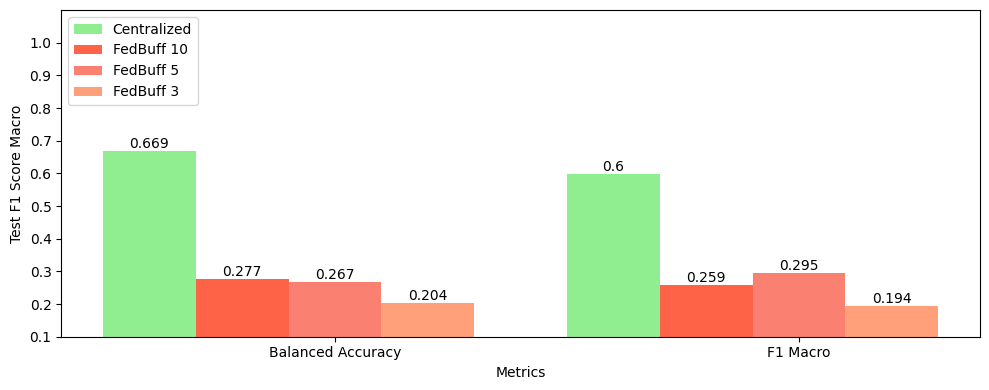

Effect size of best FedBuff performance:
 Bal Acc 0.8063 F1 Macro 0.6234


In [791]:
bal_acc_values = [
    test_result_all_classes_centralized['Bal Acc'].max(),
    test_results_multiclass_fedbuff_10['Bal Acc'].max(),
    test_results_multiclass_fedbuff_5['Bal Acc'].max(),
    test_results_multiclass_fedbuff_3['Bal Acc'].max()
]

f1_macro_values = [
    test_result_all_classes_centralized['F1 Macro'].max(),
    test_results_multiclass_fedbuff_10['F1 Macro'].max(),
    test_results_multiclass_fedbuff_5['F1 Macro'].max(),
    test_results_multiclass_fedbuff_3['F1 Macro'].max()
]
colors = ('lightgreen', 'tomato', 'salmon', 'lightsalmon')
sources = ['Centralized', 'FedBuff 10', 'FedBuff 5', 'FedBuff 3']
plot_metric_comparison(
    bar_names=metric_names,
    subbar_names=sources,
    plot_data=[bal_acc_values, f1_macro_values],
    colors=colors,
    plot_title="All classes, test metrics comparison of best models: Centralized vs. FedBuff",
    legend_pos="upper left",
    lower_y_lim=0.1
)
effect_size_bal_acc = effect_size(bal_acc_values[0], max(bal_acc_values[1:4]))
effect_size_f1_macro = effect_size(f1_macro_values[0], max(f1_macro_values[1:4]))

print(
    "Effect size of best FedBuff performance:\n",
    f"Bal Acc {effect_size_bal_acc:.4f}",
    f"F1 Macro {effect_size_f1_macro:.4f}",
)

In [812]:
performance_data = []
for model, tl in multiclass_model_configs:
    _, centralized_f1_macro = get_result_values(
        test_result_all_classes_centralized,
        model=model,
        transfer_learning=tl,
    )
    _, fedavg_f1_macro = get_result_values(
        fedavg_results_multiclass,
        model=model,
        transfer_learning=tl,
        reduction='max'
    )
    _, fedbuff_f1_macro = get_result_values(
        fedbuff_results_multiclass,
        model=model,
        transfer_learning=tl,
        reduction='max'
    )
    performance_data.append([centralized_f1_macro, fedavg_f1_macro, fedbuff_f1_macro])

All classes, test F1 score macro comparison between model configurations


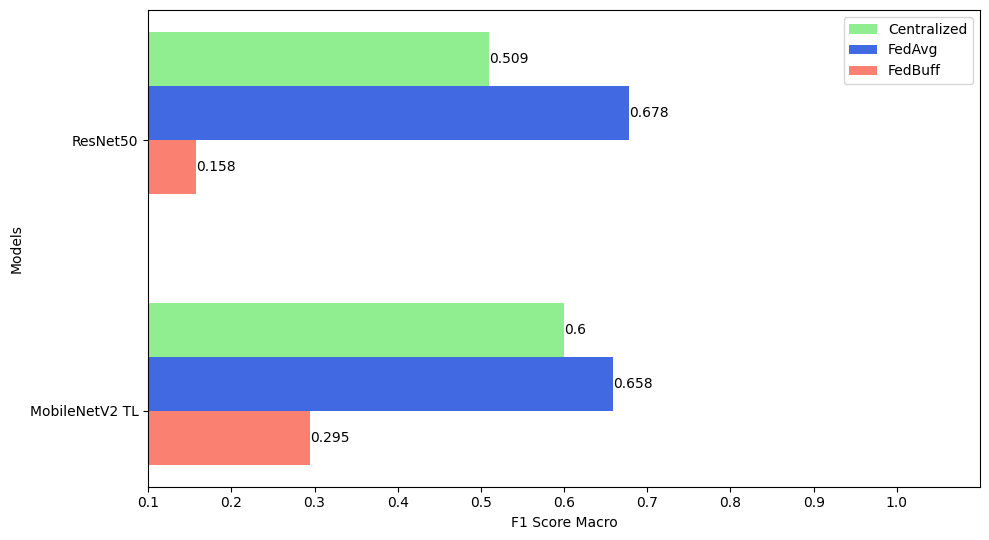

ResNet50/Centralized FedAvg: 0.3454
 ResNet50/Centralized FedBuff: 0.7718
 MobileNet-TL/Centralized FedAvg: 0.1220
 MobileNet-TL/Centralized FedBuff: 0.6234



In [813]:
colors = ('lightgreen', 'royalblue', 'salmon')
plot_metric_comparison(
    bar_names=[f"{model}{' TL' if tl else ''}" for model, tl in multiclass_model_configs],
    subbar_names=['Centralized', 'FedAvg', 'FedBuff'],
    plot_data=performance_data,
    colors=colors,
    plot_title="All classes, test F1 score macro comparison between model configurations",
    horizontal=True,
    xlabel='Models',
    ylabel='F1 Score Macro',
    height=5.5,
    lower_y_lim=0.1,
    legend_pos="upper right"
)

effect_size_resnet50_fedavg = effect_size(performance_data[0][0], performance_data[0][1])
effect_size_resnet50_fedbuff = effect_size(performance_data[0][0], performance_data[0][2])

effect_size_mobilenet_tl_fedavg = effect_size(performance_data[1][0], performance_data[1][1])
effect_size_mobilenet_tl_fedbuff = effect_size(performance_data[1][0], performance_data[1][2])

print(
    f"ResNet50/Centralized FedAvg: {effect_size_resnet50_fedavg:.4f}\n",
    f"ResNet50/Centralized FedBuff: {effect_size_resnet50_fedbuff:.4f}\n",
    f"MobileNet-TL/Centralized FedAvg: {effect_size_mobilenet_tl_fedavg:.4f}\n",
    f"MobileNet-TL/Centralized FedBuff: {effect_size_mobilenet_tl_fedbuff:.4f}\n",
)

TODO:
See how long it took best models (f1 macro) to converge for centralized, fedavg, fedbuff. And also show intermediate values.
Add table to compare our results to other work

Discussion:
Replicate results from fl oct paper with different dataset
Could not reproduce results from octdl paper on multilclass. But FedAvg behaviour was identical to binary classification. 

In [895]:
resnet_studies = []
mobilenet_studies = []

for strategy in ["FedAvg", "FedBuff"]:
    for cpr in [5, 3]:
        resnet_study_name = get_fl_study_name(
            classes=amd_classes,
            model='ResNet18',
            transfer_learning=True,
            loss_fn_type=LOSS_TYPE,
            optimization_mode=OPTIMIZATION_MODE,
            n_clients=20,
            n_clients_per_round=cpr
        )
        resnet_studies.append(
            (load_study(resnet_study_name, f"results_{strategy}"), strategy, cpr)
        )
        
        mobilenet_study_name = get_fl_study_name(
            classes=amd_classes,
            model='MobileNetV2',
            transfer_learning=True,
            loss_fn_type=LOSS_TYPE,
            optimization_mode=OPTIMIZATION_MODE,
            n_clients=20,
            n_clients_per_round=cpr
        )
        mobilenet_studies.append(
            (load_study(mobilenet_study_name, f"results_{strategy}"), strategy, cpr)
        )

In [896]:
def get_until_max(lst):
    max_value = max(lst)
    max_index = lst.index(max_value)
    return lst[:max_index + 1]

In [911]:
def plot_training_curve(
    studies_with_info: list[tuple[optuna.Study, FLStrategy ,int]],
    title: str,
    centralized_score: float,
    colors=["royalblue", "deepskyblue", "tomato", "lightsalmon"],
):
    plt.figure(figsize=(10, 4))
    font = {'size': 10}
    linewidth = 2
    plt.rc('font', **font)
    plt.axhline(y=centralized_score, color="forestgreen", linestyle='--', linewidth=1.5,
                    label=f"Centralized")
    for i, ((study, strategy, cpr), color) in enumerate(zip(studies_with_info, colors)):
        best_trial = study.best_trial
        values = get_until_max(list(best_trial.intermediate_values.values()))
        plt.plot(
            [(i+1)*cpr for i in range(len(values))], values,
            label=f"{strategy} - {cpr} clients",
            linewidth=linewidth,
            c=colors[i]
        )
    plt.xlabel("Number of updates")
    plt.ylabel("F1 Score Macro")
    plt.legend()
    plt.grid()
    plt.xlim(0,260)
    plt.ylim(0.1, 1.0)
    if not os.path.exists(FIGS_FOLDER):
        os.makedirs(FIGS_FOLDER)
    plt.savefig(os.path.join(FIGS_FOLDER , f"{title}.png"), bbox_inches='tight')
    print(title)
    plt.show()

Learning curve ResNet18 (TL), AMD diagnosis, FedAvg vs. FedBuff


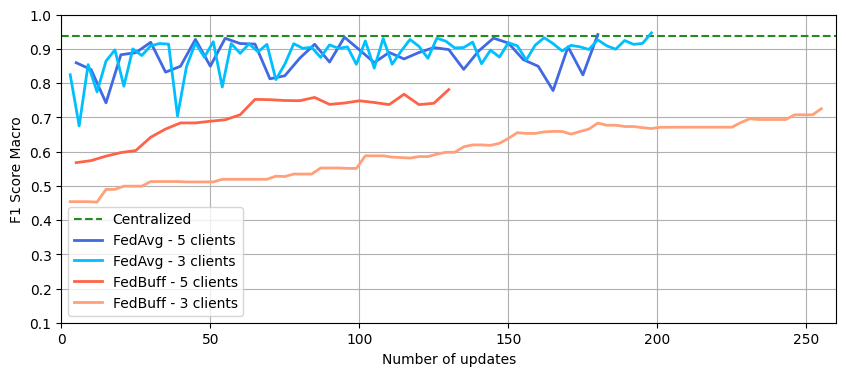

In [912]:
plot_training_curve(resnet_studies, "Learning curve ResNet18 (TL), AMD diagnosis, FedAvg vs. FedBuff", f1_macro_centr_resnet18_tl)

Learning curve MobileNet (TL), AMD diagnosis, FedAvg vs. FedBuff


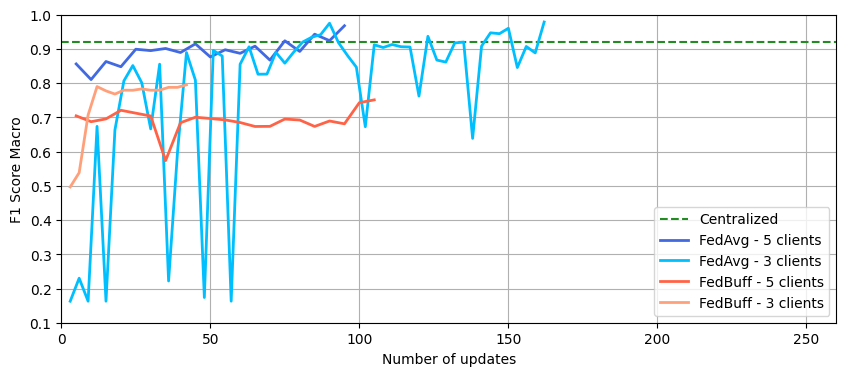

In [913]:
plot_training_curve(mobilenet_studies, "Learning curve MobileNet (TL), AMD diagnosis, FedAvg vs. FedBuff", f1_macro_centr_mobilenet_tl)

In [800]:
sum([0.9279, 0.9414, 0.8755, 0.9074]) / 4

0.9130499999999999

In [801]:
sum([0.9455, 0.9367, 0.8678, 0.9252]) / 4

0.9188000000000001

In [805]:
sum([0.9582, 0.9414, 0.9316, 0.9189]) / 4

0.9375249999999999